In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import h5py
from skimage.measure import shannon_entropy as entropy
from tqdm import tqdm
from scipy.io import savemat
import os
from pathlib import Path

from ELICUtils.encoding.rle import *


In [29]:
def plot_latent_distributions(
        filepath="/scratch/zb7df/data/latents/",
        filename="latent_tensors_lambda1.h5",
        dataset_name="y_hat"
):
    with h5py.File(filepath+filename, 'r') as f:
        data = f[dataset_name][:]
        print(f"{dataset_name}: {type(data)} | {data.shape}")

    # Overall distribution
    plt.figure(figsize=(6, 4))

    # Plot data distribution
    plt.hist(data.flatten(), bins=100, density=True)
    plt.title('Overall Distribution')
    plt.xlabel('Value')
    plt.ylabel('Density')
    
    plt.tight_layout()
    plt.show()

    print("\nOverall statistics:")
    print(f"Mean: {np.mean(data):.4f}")
    print(f"Std: {np.std(data):.4f}")
    print(f"Distinct: {len(np.unique(data))}")
    print(f"Equal zero: {100 * np.mean(data == 0):.2f}%")
    print(f"Entropy: {entropy(data):.4f}")

    return data.squeeze()


In [30]:
y = plot_latent_distributions(filename="latent_tensors_lambda1.h5", dataset_name="y")
y_hat = plot_latent_distributions(filename="latent_tensors_lambda1.h5", dataset_name="y_hat")
# z_hat = plot_latent_distributions(filename="latent_tensors_lambda1.h5", dataset_name="z_hat")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/scratch/zb7df/data/latents/latent_tensors_lambda1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [305]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

plt.rcParams['mathtext.fontset'] = 'stix'

### Energy by Channel

In [67]:
def plot_channel_signal(
        input_signal,
        title="Signal by Channel",
        splits=[0, 16, 32, 64, 128, 320],
        plot_means=True,
        plot_medians=False,
        sorted_idx=None
):
    if sorted_idx is not None:
        input_signal = input_signal[sorted_idx]

    fig, ax = plt.subplots()
    ax.plot(input_signal)
    plt.title(title)

    y_vals_mean = []
    y_vals_median = []
    x_mins = []
    x_maxs = []
    for i in range(len(splits)-1):
        chn_vals = input_signal[splits[i]:splits[i+1]]
        chn_grp_mean = np.mean(chn_vals)
        chn_grp_median = np.median(chn_vals)
        y_vals_mean.append(chn_grp_mean)
        y_vals_median.append(chn_grp_median)
        x_mins.append(splits[i])
        x_maxs.append(splits[i+1])

        # if 0 < i < (len(splits)-1):
            # ax.axvline(x=splits[i], color='darkorange', linestyle='dotted', alpha=1)
        
        ax.axvspan(splits[i], splits[i+1], color='lightgray', alpha=0.8 if i % 2 == 0 else 0.4)

    if plot_means:
        ax.hlines(y_vals_mean, x_mins, x_maxs, colors="darkorange")
    elif plot_medians:
        ax.hlines(y_vals_median, x_mins, x_maxs, colors="darkorange")
    
    plt.show()


def get_channel_stats(input_signal):
    N, C, H, W = input_signal.shape

    channel_entropy_list = []
    channel_energy_list = []
    channel_zeros_list = []
    channel_runs_list = []
    for c in tqdm(range(C)):
        entropy_list = []
        energy_list = []
        zeros_list = []
        runs_list = []
        for i in range(N):
            arr = input_signal[i, c, :, :].ravel()
            entropy_list.append(entropy(arr))
            energy_list.append(np.var(arr))
            zeros_list.append(np.mean(arr == 0))
            vals, lens = rle_encode(arr)
            runs_list.append(np.mean(lens))

        channel_entropy_list.append(np.mean(entropy_list))
        channel_energy_list.append(np.mean(energy_list))
        channel_zeros_list.append(np.mean(zeros_list))
        channel_runs_list.append(np.mean(runs_list))

    channel_entropy_list = np.array(channel_entropy_list)
    channel_energy_list = np.array(channel_energy_list)
    channel_zeros_list = np.array(channel_zeros_list)
    channel_runs_list = np.array(channel_runs_list)

    print(f"Entropy #: {len(channel_entropy_list)}")
    print(f"Energy #: {len(channel_energy_list)}")
    print(f"Zeros #: {len(channel_zeros_list)}")
    print(f"Run Lens #: {len(channel_runs_list)}")

    return channel_entropy_list, channel_energy_list, channel_zeros_list, channel_runs_list

    

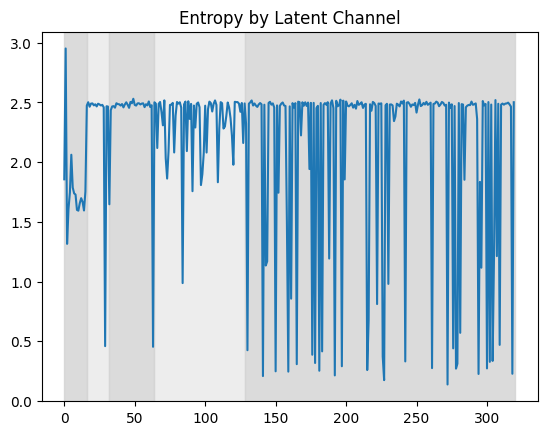

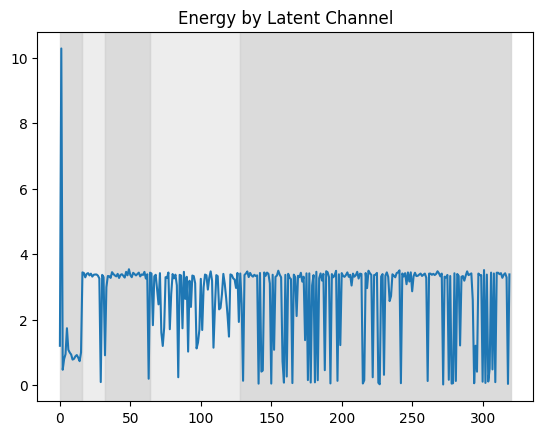

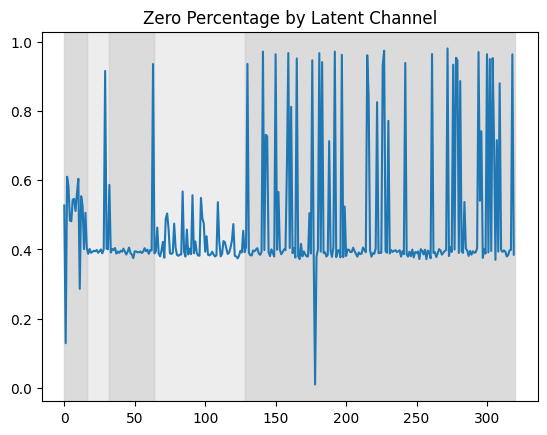

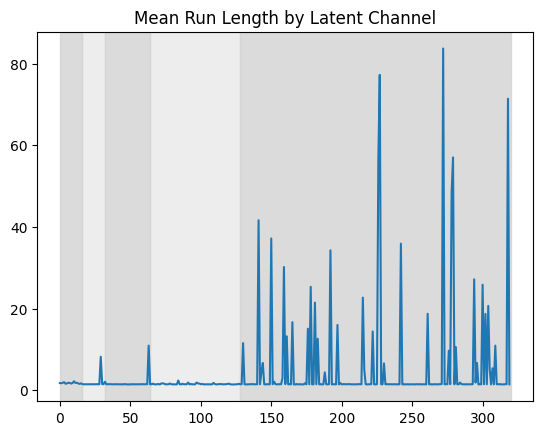

In [25]:
# entropies, energies, zeroes, runs = get_channel_stats(y_hat)

plot_channel_signal(entropies, plot_means=False, plot_medians=False, title="Entropy by Latent Channel")
plot_channel_signal(energies, plot_means=False, plot_medians=False, title="Energy by Latent Channel")
plot_channel_signal(zeroes, plot_means=False, plot_medians=False, title="Zero Percentage by Latent Channel")
plot_channel_signal(runs, plot_means=False, plot_medians=False, title="Mean Run Length by Latent Channel")

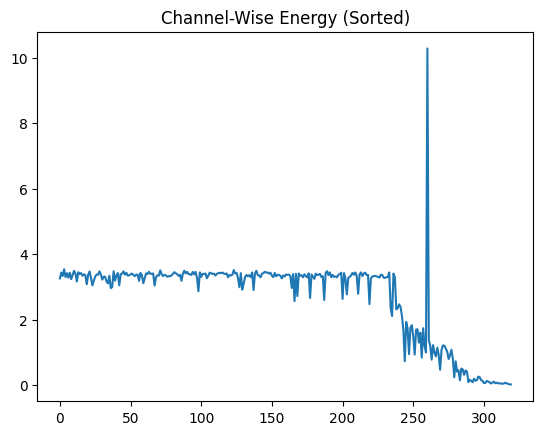

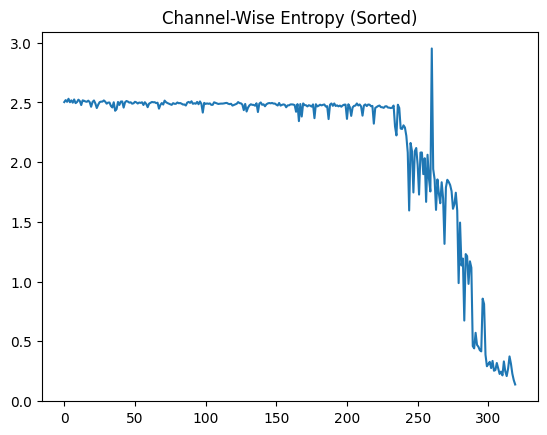

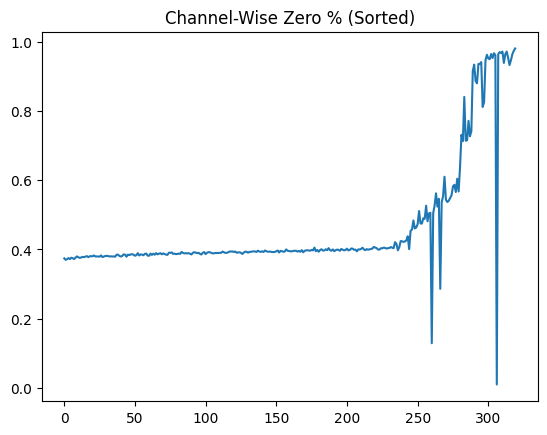

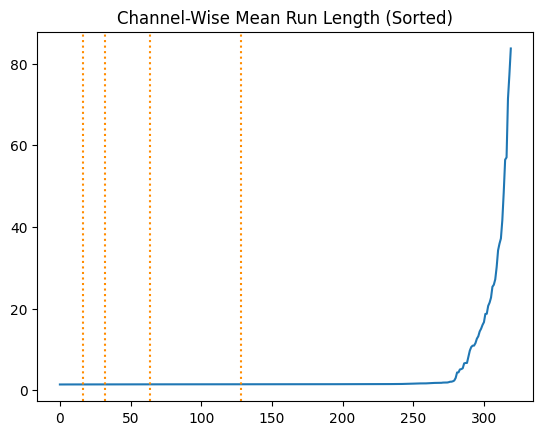

In [174]:
sorted_idx = np.argsort(runs)

plot_channel_signal(energies, plot_means=False, splits=[], title="Channel-Wise Energy (Sorted)", sorted_idx=sorted_idx)
plot_channel_signal(entropies, plot_means=False, splits=[], title="Channel-Wise Entropy (Sorted)", sorted_idx=sorted_idx)
plot_channel_signal(zeroes, plot_means=False, splits=[], title="Channel-Wise Zero % (Sorted)", sorted_idx=sorted_idx)
plot_channel_signal(runs, plot_means=False, title="Channel-Wise Mean Run Length (Sorted)", sorted_idx=sorted_idx)

### Histograms

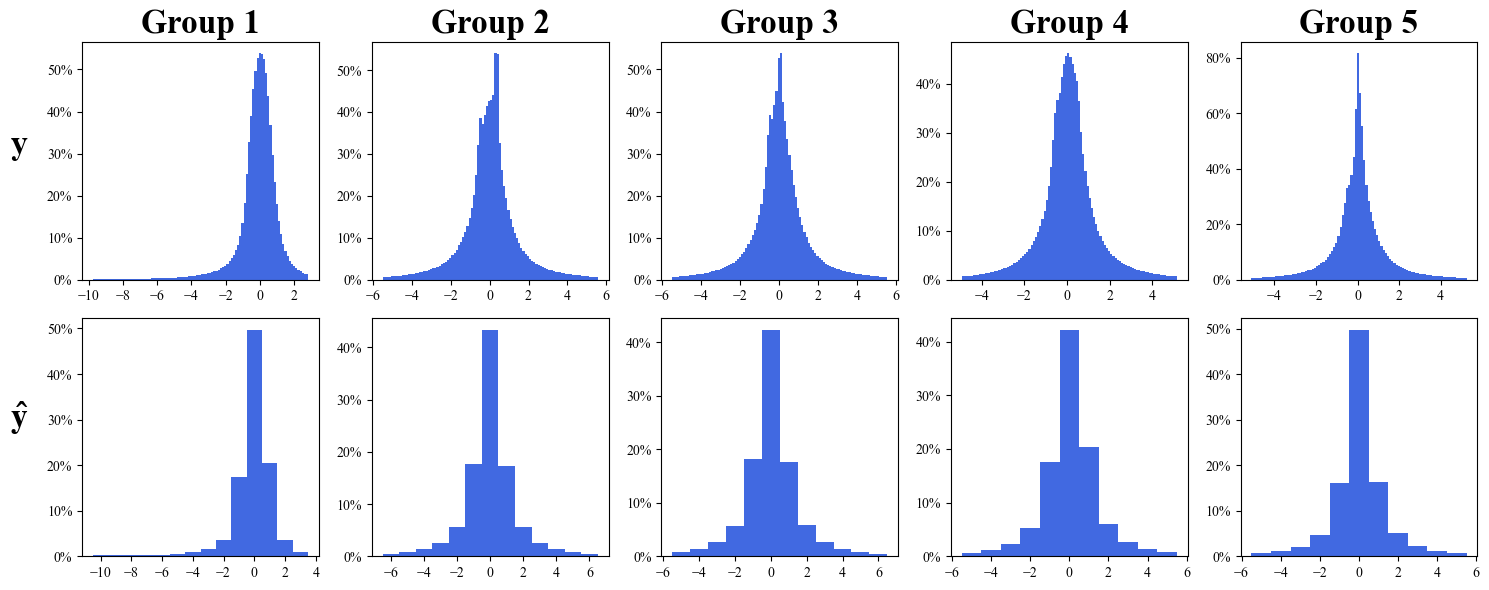

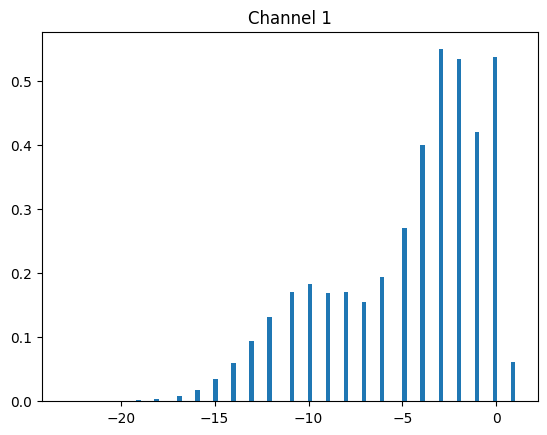

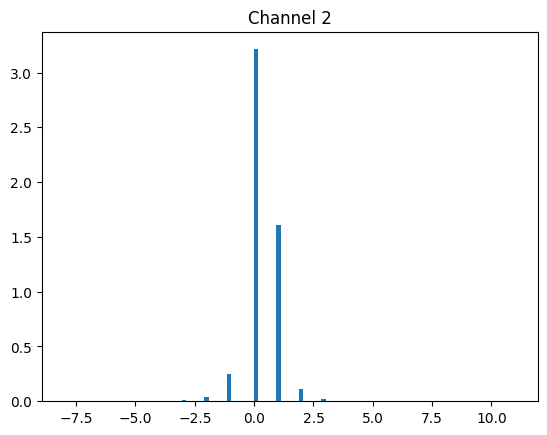

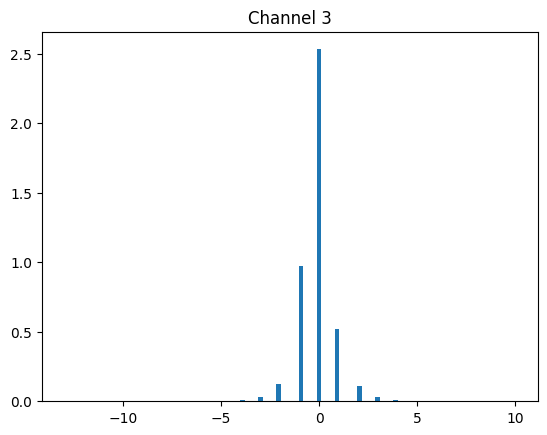

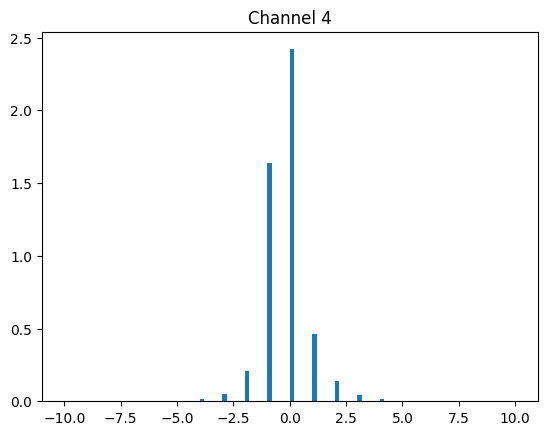

In [312]:
for i in range(5):
    plt.hist(y_hat[:, i, :, :].flatten(), bins=100, density=True)
    plt.title(f"Channel {i}")
    plt.show()


y: <class 'numpy.ndarray'> | (1000, 1, 320, 16, 16)


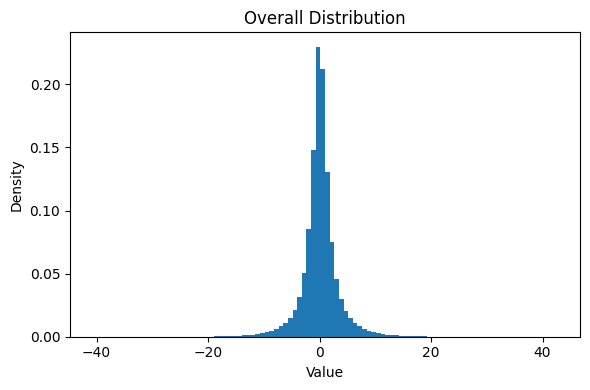


Overall statistics:
Mean: 0.0758
Std: 3.2623
Distinct: 36629800
Equal zero: 0.00%
Entropy: 24.7388
y_hat: <class 'numpy.ndarray'> | (1000, 320, 16, 16)


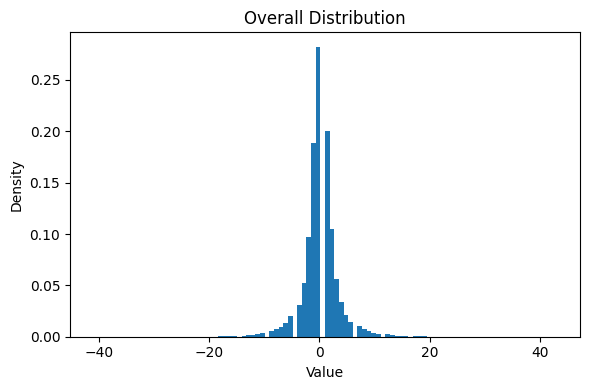


Overall statistics:
Mean: 0.0757
Std: 3.2749
Distinct: 84
Equal zero: 23.71%
Entropy: 3.4970


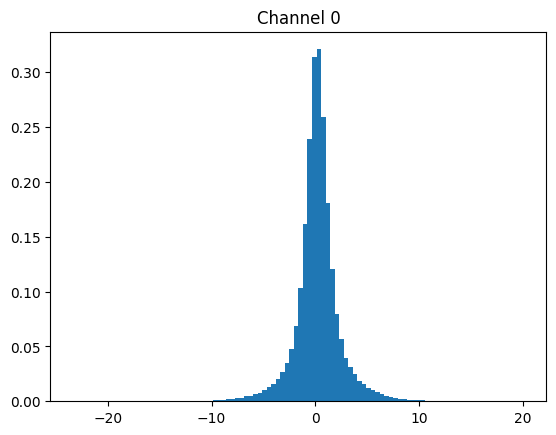

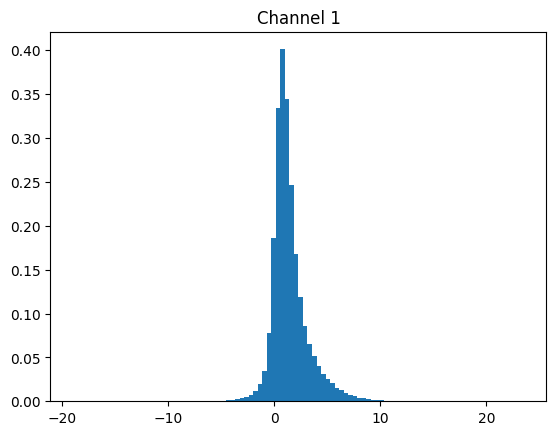

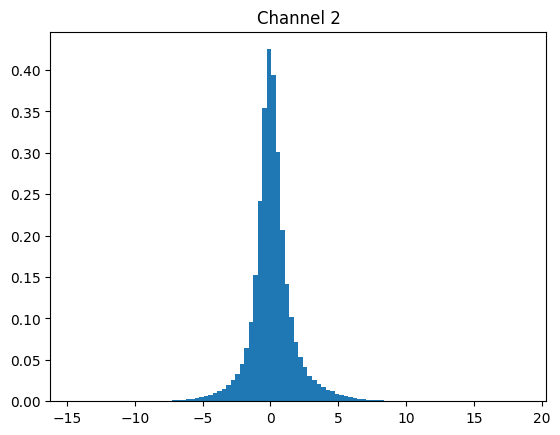

In [ ]:
plt.hist(y_4[:, 0, :, :].flatten(), bins=100, density=True)
plt.title("Channel 0")
plt.show()

    for i in range(5):
        ax_y = axs[0, i]
        y_slice = y[:, splits[i]:splits[i+1], :, :].flatten()
        y_slice = y_slice[np.percentile(y_slice, 1) <= y_slice]
        y_slice = y_slice[y_slice <= np.percentile(y_slice, 99)]
        ax_y.hist(y_slice, bins=100, color=color, density=True)
        ax_y.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
        ax_y.xaxis.set_major_locator(MaxNLocator(integer=True))
        # ax_y.set_ylim(top=1)
        ax_y.set_title(f"Group {i+1}", size=24, weight="bold")
        
        ax_yhat = axs[1, i]
        y_hat_slice = y_hat[:, splits[i]:splits[i+1], :, :].flatten().astype(int)
        y_hat_slice = y_hat_slice[np.percentile(y_hat_slice, 1) <= y_hat_slice]
        y_hat_slice = y_hat_slice[y_hat_slice <= np.percentile(y_hat_slice, 99)]
        n_unique = len(np.unique(y_hat_slice))
        ax_yhat.hist(y_hat_slice, bins=np.arange(y_hat_slice.min() - 0.5, y_hat_slice.max() + 1.5, 1), align="mid",
                color=color, density=True)
        ax_yhat.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
        ax_yhat.xaxis.set_major_locator(MaxNLocator(integer=True))
        # ax_yhat.set_ylim(top=1)

    axs[0, 0].set_ylabel("y", size=24, weight="bold", rotation="horizontal", labelpad=20)
    axs[1, 0].set_ylabel(r"$\mathbf{\hat{y}}$", size=24, weight="bold", rotation="horizontal", labelpad=20)
    plt.tight_layout()
    plt.show()


plot_latent_histograms(color="royalblue")


# Plot latents

[ 60 158 109 216]


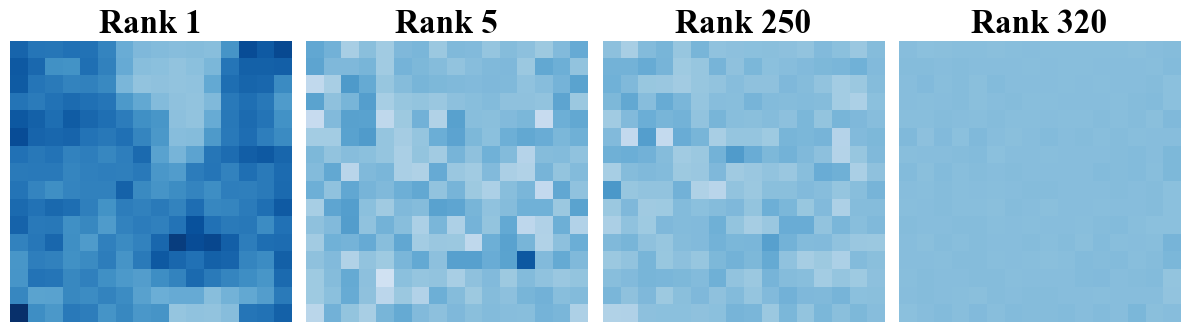

In [313]:
data = y_4

img_idx = [0, 10, 20, 30]
rank = [1, 50, 250, 320]
titles = [f"Rank {i}" for i in rank]
print(sorted_idx[[r-1 for r in rank]])

for j in range(len(img_idx)):
    img = data[img_idx[j], :, :, :].squeeze()
    vmin = np.min(img)
    vmax = np.max(img)
    imgs = []
    for i in rank:
        idx = sorted_idx[i-1]
        imgs.append(img[idx, :, :])

    fig, axs = plt.subplots(1, 4, figsize=(12, 12))
    for i, ax in enumerate(axs):
        ax.imshow(imgs[i], cmap='Blues_r', vmin=vmin, vmax=vmax)
        ax.set_title(titles[i], size=24, weight="bold")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Val/Len Distributions

In [53]:
import torch
import heapq
from collections import Counter
from bitarray import bitarray

from rle import *
from benchmarking import *


def build_huffman_codebook(arr):
    """
    Builds a Huffman codebook for a numpy array of non-negative integers.
    Returns a list `codebook` where index i gives the bitstring for symbol i.
    """
    freq = Counter(arr.tolist())
    if len(freq) == 1:
        # Edge case: only one symbol
        symbol = next(iter(freq))
        max_sym = symbol
        codebook = ["0"] * (max_sym + 1)
        codebook[symbol] = "0"
        return codebook

    # Build Huffman tree using a min-heap
    heap = [[wt, [sym, ""]] for sym, wt in freq.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

    # Extract codes
    huff_codes = sorted(heapq.heappop(heap)[1:], key=lambda p: p[0])

    # Create list-based codebook
    max_sym = max(freq.keys())
    codebook = [""] * (max_sym + 1)
    for sym, code in huff_codes:
        codebook[sym] = code

    return codebook


def huffman_encode_with_codebook(arr, codebook):
    """
    Encodes a numpy array of non-negative integers using a precomputed list-based codebook.
    Returns a bitarray object containing the encoded bits.
    """
    encoded = bitarray(endian='big')
    for val in arr:
        encoded.extend(codebook[val])
    return encoded


def _rle_bypass_encode(y):
    y_shape = y.shape
    y_hat = torch.flatten(y).round().int().cpu().numpy()

    vals, lens = rle_encode_v1(y_hat)
    start = time.time()
    vals_encoded = exp_golomb_encode_lookup(vals)
    eg_time = time.time() - start
    print(f"EG Vals encoding time: {eg_time:.4f} seconds")
    start = time.time()
    lens_encoded = exp_golomb_encode_unsigned_lookup(lens)
    eg_time = time.time() - start
    print(f"EG Lens encoding time: {eg_time:.4f} seconds")

    start = time.time()
    vals_codebook = build_huffman_codebook(vals+24)
    huffman_codebook_time = time.time() - start
    print(f"H Vals codebook time: {huffman_codebook_time:.4f} seconds")
    start = time.time()
    lens_codebook = build_huffman_codebook(lens)
    huffman_codebook_time = time.time() - start
    print(f"H Lens codebook time: {huffman_codebook_time:.4f} seconds")

    start = time.time()
    vals_enc_h = huffman_encode_with_codebook(vals+24, vals_codebook)
    huffman_time = time.time() - start
    print(f"H Vals encoding time: {huffman_time:.4f} seconds")
    start = time.time()
    lens_enc_h = huffman_encode_with_codebook(lens, lens_codebook)
    huffman_time = time.time() - start
    print(f"H Lens encoding time: {huffman_time:.4f} seconds")

    # Just passing the widths directly for now
    # Should ultimately be a header or interleaved bitstream
    vals_len = len(vals_encoded)
    lens_len = len(lens_encoded)
    y_strings = vals_encoded + lens_encoded

    vals_len_h = len(vals_enc_h)
    lens_len_h = len(lens_enc_h)

    header = {
        "y_shape": y_shape,
        "vals_len": vals_len,
        "lens_len": lens_len,
        "tot_len_eg": vals_len + lens_len,
        "vals_enc_h": vals_len_h,
        "lens_enc_h": lens_len_h,
        "tot_len_h": vals_len_h + lens_len_h,
    }

    # Convert y_hat to tensor
    y_hat = y_hat.reshape(y_shape)
    y_hat = torch.from_numpy(y_hat).float()

    return header, vals_codebook, lens_codebook

In [54]:
header, vals_codebook, lens_codebook = _rle_bypass_encode(torch.from_numpy(y))

for key, value in header.items():
    print(f"{key}: {value}")


EG Vals encoding time: 9.1725 seconds
EG Lens encoding time: 11.1481 seconds
H Vals codebook time: 1.5859 seconds
H Lens codebook time: 1.6651 seconds
H Vals encoding time: 3.9331 seconds
H Lens encoding time: 3.5161 seconds
y_shape: torch.Size([1000, 320, 16, 16])
vals_len: 166130880
lens_len: 82739088
tot_len_eg: 248869968
vals_enc_h: 152038223
lens_enc_h: 76509468
tot_len_h: 228547691


In [297]:
rc_df = pd.DataFrame({
    "Configuration": ["Baseline", "1", "2", "3", "4", "5", "1-2", "1-3", "1-4", "1-5"],
    "BPP": [1.167, 1.202, 1.193, 1.220, 1.292, 1.514, 1.228, 1.281, 1.406, 1.754],
    "Encoding Time": [102, 85, 84, 84, 84, 82, 66, 48, 29, 9],
    "Decoding Time": [57, 49, 48, 48, 50, 54, 39, 30, 22, 18],
    "Combined Time": [159, 134, 132, 132, 134, 136, 105, 78, 51, 28]
})

rc_df

,Configuration,BPP,Encoding Time,Decoding Time,Combined Time
0,Baseline,1.167,102,57,159
1,1,1.202,85,49,134
2,2,1.193,84,48,132
3,3,1.220,84,48,132
4,4,1.292,84,50,134
5,5,1.514,82,54,136
6,1-2,1.228,66,39,105
7,1-3,1.281,48,30,78
8,1-4,1.406,29,22,51
9,1-5,1.754,9,18,28


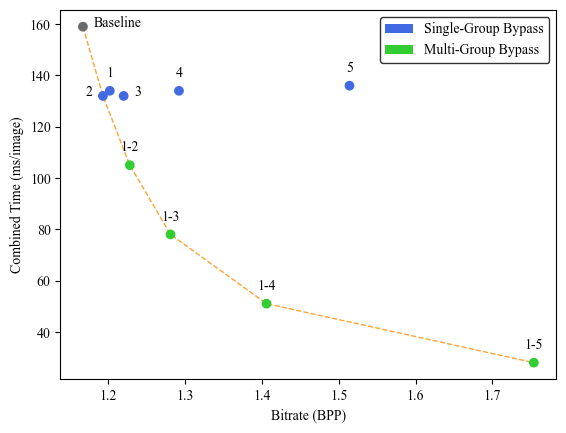

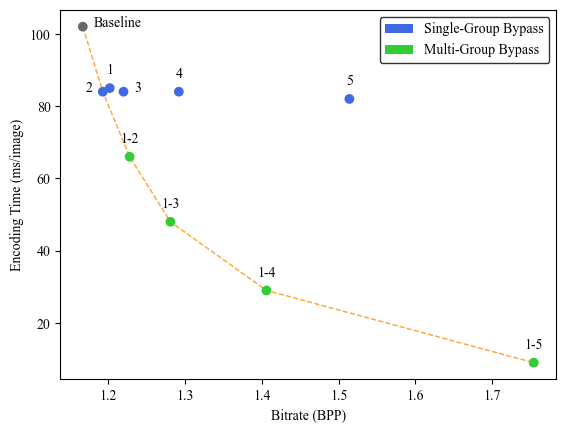

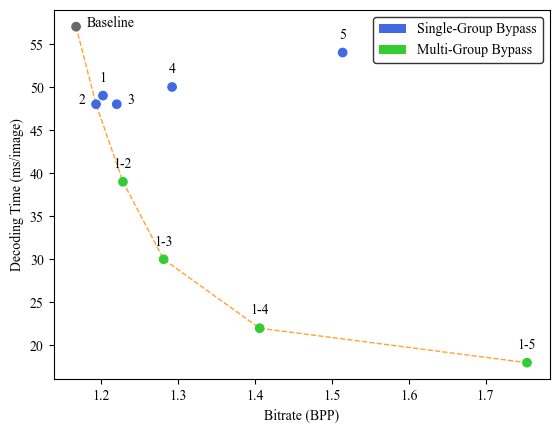

In [300]:
def plot_rate_complexity(y_col="Combined Time"):
    baseline_color = "dimgrey"
    single_color = "royalblue"
    multi_color = "limegreen"
    colors = [baseline_color] + [single_color]*5 + [multi_color]*4
    offsets = [(25, 0), (0, 10), (-10, 0), (10, 0), (0, 10), (0, 10), (0, 10), (0, 10), (0, 10), (0, 10)]

    x_points = rc_df["BPP"]
    y_points = rc_df[y_col]
    labels = rc_df["Configuration"]

    pareto_idx = [0, 2, 6, 7, 8, 9]
    pareto_x = x_points[pareto_idx]
    pareto_y = y_points[pareto_idx]

    plt.plot(pareto_x, pareto_y, linestyle="--", color="darkorange", linewidth=1, alpha=0.8, zorder=1)
    plt.scatter(x_points, y_points, c=colors, zorder=2)
    for i, (x, y) in enumerate(zip(x_points, y_points)):
        plt.annotate(labels[i],
                    (x, y),
                    textcoords="offset points",
                    xytext=offsets[i],
                    ha='center')
    plt.xlabel("Bitrate (BPP)")
    plt.ylabel(f"{y_col} (ms/image)")

    if y_col == "Combined Time":
        text_loc = (1.2, 50)
        arrow_start = (1.255, 57.5)
        arrow_end = (1.31, 70)
    elif y_col == "Encoding Time":
        text_loc = (1.23, 25)
        arrow_start = (1.28, 30)
        arrow_end = (1.33, 40)
    elif y_col == "Decoding Time":
        text_loc = (1.23, 21)
        arrow_start = (1.28, 23)
        arrow_end = (1.325, 27)

    # plt.text(text_loc[0], text_loc[1], "Pareto Frontier", color="darkorange")
    # plt.annotate("", xytext=arrow_start, xy=arrow_end, arrowprops=dict(arrowstyle="-|>", color="darkorange"))
    handles = [
        Patch(facecolor="royalblue", label="Single-Group Bypass"),
        Patch(facecolor="limegreen", label="Multi-Group Bypass")
    ]
    plt.legend(handles=handles, loc='upper right', edgecolor='black', frameon=True)
    plt.show()


plot_rate_complexity(y_col="Combined Time")
plot_rate_complexity(y_col="Encoding Time")
plot_rate_complexity(y_col="Decoding Time")


### Time per Channel Group (ISCAS)

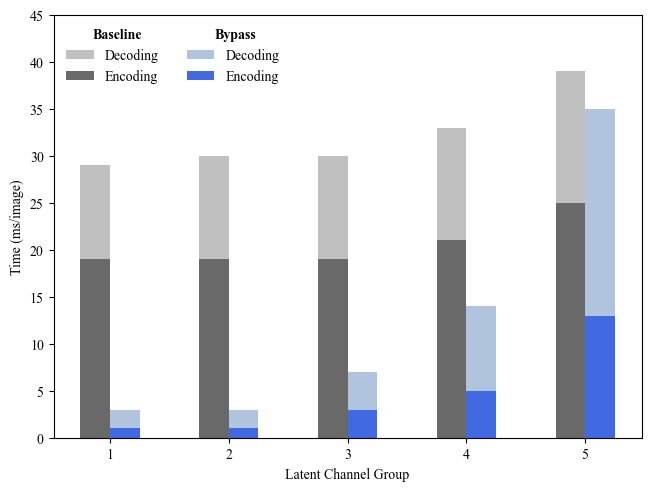

In [292]:
groups = ["Group 1", "Group 2", "Group 3", "Group 4", "Group 5"]
times = {
    "Baseline": {
        "enc": [19, 19, 19, 21, 25],
        "dec": [10, 11, 11, 12, 14]
    },
    "Bypass": {
        "enc": [1, 1, 3, 5, 13],
        "dec": [2, 2, 4, 9, 22]
    },
    "Diff": ["-89%", "-88%", "-77%", "-58%", "-10%"]
}
x = np.arange(len(groups))+1
width = 0.25
fig, ax = plt.subplots(layout="constrained")

var = "Baseline"
multiplier = -0.5
offset = width * multiplier
bottom = np.zeros(len(groups))
ax.bar(x+offset, times[var]["enc"], width, bottom=bottom, label=var, color="dimgrey")
bottom += times[var]["enc"]
ax.bar(x+offset, times[var]["dec"], width, bottom=bottom, label=var, color="silver")

var = "Bypass"
multiplier = 0.5
offset = width * multiplier
bottom = np.zeros(len(groups))
ax.bar(x+offset, times[var]["enc"], width, label=var, color="royalblue")
bottom += times[var]["enc"]
bars = ax.bar(x+offset, times[var]["dec"], width, bottom=bottom, label=var, color="lightsteelblue")

# Bar labels (relative differences)
# for i, bar in enumerate(bars):
#     ax.text(bar.get_x()+0.02+bar.get_width()/2, bar.get_height()+bottom[i]+0.5,
#             times["Diff"][i], ha="center", va="bottom", color="black")

ax.set_ylabel("Time (ms/image)")
ax.set_xlabel("Latent Channel Group")
ax.set_ylim(0, 45)
handles = [
    Patch(facecolor="silver", label="Decoding"),
    Patch(facecolor="dimgrey", label="Encoding"),
    Patch(facecolor="lightsteelblue", label="Decoding"),
    Patch(facecolor="royalblue", label="Encoding")
]
first_legend = ax.legend(ncols=2, handles=handles, bbox_to_anchor=(0, 0.95), loc='upper left', edgecolor='black', frameon=False)
ax.text(0.85, 42.5, "Baseline", weight="bold")
ax.text(1.88, 42.5, "Bypass", weight="bold")

plt.show()

### Time per Channel per Group (ICIP)

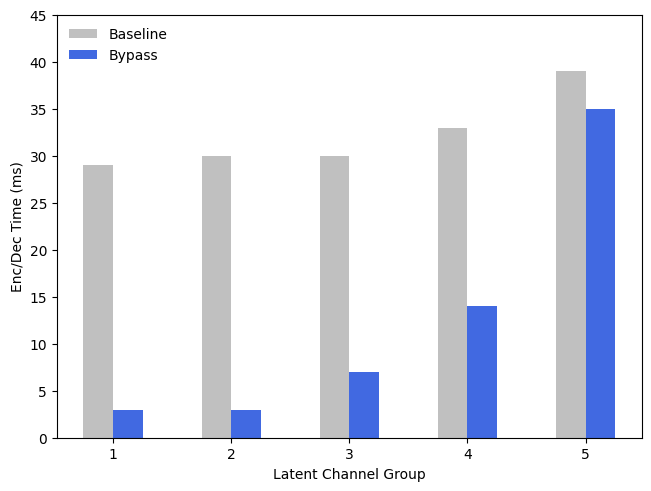

In [ ]:
groups = ["Group 1", "Group 2", "Group 3", "Group 4", "Group 5"]
times = {
    "Baseline": {
        "tot": [29, 30, 30, 32, 39],
        "norm": [1.83, 1.85, 0.95, 0.50, 0.20]
    },
    "Bypass": {
        "tot": [3, 4, 7, 14, 35],
        "norm": [0.21, 0.22, 0.22, 0.21, 0.18]
    },
    "Diff": ["-89%", "-88%", "-77%", "-58%", "-10%"]
}
x = np.arange(len(groups))+1
width = 0.25
fig, ax = plt.subplots(layout="constrained")

var = "Baseline"
multiplier = -0.5
offset = width * multiplier
bottom = np.zeros(len(groups))
ax.bar(x+offset, times[var]["tot"], width, label=var, color="silver")

var = "Bypass"
multiplier = 0.5
offset = width * multiplier
bottom = np.zeros(len(groups))
ax.bar(x+offset, times[var]["tot"], width, label=var, color="royalblue")

ax.set_ylabel("Enc/Dec Time (ms)")
ax.set_xlabel("Latent Channel Group")
ax.set_ylim(0, 45)
handles = [
    Patch(facecolor="silver", label="Baseline"),
    Patch(facecolor="royalblue", label="Bypass")
]
first_legend = ax.legend(ncols=1, handles=handles, bbox_to_anchor=(0, 1), loc='upper left', edgecolor='black', frameon=False)

plt.show()

100.0


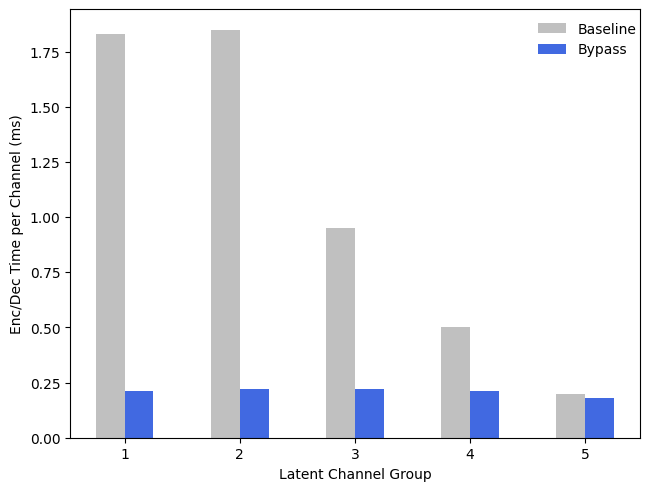

In [28]:
groups = ["Group 1", "Group 2", "Group 3", "Group 4", "Group 5"]
times = {
    "Baseline": {
        "tot": [29, 30, 30, 32, 39],
        "norm": [1.83, 1.85, 0.95, 0.50, 0.20]
    },
    "Bypass": {
        "tot": [3, 4, 7, 14, 35],
        "norm": [0.21, 0.22, 0.22, 0.21, 0.18]
    },
    "Diff": ["-89%", "-88%", "-77%", "-58%", "-10%"]
}
x = np.arange(len(groups))+1
width = 0.25
fig, ax = plt.subplots(layout="constrained")

var = "Baseline"
multiplier = -0.5
offset = width * multiplier
bottom = np.zeros(len(groups))
ax.bar(x+offset, times[var]["norm"], width, label=var, color="silver")

var = "Bypass"
multiplier = 0.5
offset = width * multiplier
bottom = np.zeros(len(groups))
ax.bar(x+offset, times[var]["norm"], width, label=var, color="royalblue")

ax.set_ylabel("Enc/Dec Time per Channel (ms)")
ax.set_xlabel("Latent Channel Group")
# ax.set_ylim(0, 45)
handles = [
    Patch(facecolor="silver", label="Baseline"),
    Patch(facecolor="royalblue", label="Bypass")
]
first_legend = ax.legend(ncols=1, handles=handles, bbox_to_anchor=(0.8, 1), loc='upper left', edgecolor='black', frameon=False)

print(fig.dpi)
plt.savefig("../../research/Projects/DCT ELIC RLE Bypass/norm_time_by_channel_group.png", dpi=300)

plt.show()

In [295]:
(np.array(times["Bypass"]["enc"]) + np.array(times["Bypass"]["dec"]))/np.array([16, 16, 32, 64, 192])

array([0.1875    , 0.1875    , 0.21875   , 0.21875   , 0.18229167])

In [296]:
(np.array(times["Baseline"]["enc"]) + np.array(times["Baseline"]["dec"]))/np.array([16, 16, 32, 64, 192])

array([1.8125  , 1.875   , 0.9375  , 0.515625, 0.203125])

# Calculate Results

In [72]:
pd.set_option('display.max_columns', None)
# base_path = Path("/scratch/zb7df/data/results")
base_path = Path("/home/zb7df/dev/elic_dct/results/")
files = ["HH_bypass0_lambda1.csv", "HH_bypass1_lambda1.csv", "HH_bypass2_lambda1.csv", 
         "HH_bypass3_lambda1.csv", "HH_bypass4_lambda1.csv", "HH_bypass5_lambda1.csv", 
         "HH_bypass12_lambda1.csv", "HH_bypass123_lambda1.csv", "HH_bypass1234_lambda1.csv", 
         "HH_bypass12345_lambda1.csv"]
# files = ["HH_bypass0_lambda1.csv", "HH_bypass1_lambda1.csv", "HH_bypass2_lambda1.csv", 
#          "HH_bypass3_lambda1.csv", "HH_bypass4_lambda1.csv"]

means_list = []
for file in files:
    df = pd.read_csv(base_path / file, header=0)
    means = df.iloc[:, 1:].mean()
    means_list.append(means)

cols = ["bpp", "psnr", "ssim", "sqnr", "mape_phase", "enc_time", "dec_time", 
        "enc1_m", "enc1_s", "enc2_m", "enc2_s", "enc3_m", "enc3_s", "enc4_m", "enc4_s", "enc5_m", "enc5_s",
        "dec1_m", "dec1_s", "dec2_m", "dec2_s", "dec3_m", "dec3_s", "dec4_m", "dec4_s", "dec5_m", "dec5_s"]
enc_loop_time_cols = ["enc1_m", "enc2_m", "enc3_m", "enc4_m", "enc5_m"]
dec_loop_time_cols = ["dec1_m", "dec2_m", "dec3_m", "dec4_m", "dec5_m"]
enc_dec_sd_cols = [c.replace("_m", "_s") for c in enc_loop_time_cols + dec_loop_time_cols]
results_df = pd.DataFrame(means_list, index=[f.split('.')[0] for f in files], columns=cols)
results_df["tot_time"] = results_df["enc_time"] + results_df["dec_time"]
results_df["enc_loop_time"] = results_df[enc_loop_time_cols].sum(axis=1)
results_df["dec_loop_time"] = results_df[dec_loop_time_cols].sum(axis=1)
results_df["bpp_reduction"] = 1 - (results_df["bpp"] / 32)

enc_loop_baseline = results_df.loc["HH_bypass0_lambda1", "enc_loop_time"]
dec_loop_baseline = results_df.loc["HH_bypass0_lambda1", "dec_loop_time"]
results_df["enc_loop_reduction"] = 1 - (results_df["enc_loop_time"] / enc_loop_baseline)
results_df["dec_loop_reduction"] = 1 - (results_df["dec_loop_time"] / dec_loop_baseline)
results_df["tot_loop_time"] = results_df["enc_loop_time"] + results_df["dec_loop_time"]
results_df["tot_loop_time_sd"] = (results_df[enc_dec_sd_cols]**2).sum(axis=1)**0.5
results_df["tot_loop_reduction"] = 1 - (results_df["tot_loop_time"] / (enc_loop_baseline + dec_loop_baseline))

results_df

,bpp,psnr,ssim,sqnr,mape_phase,enc_time,dec_time,enc1_m,enc1_s,enc2_m,enc2_s,enc3_m,enc3_s,enc4_m,enc4_s,enc5_m,enc5_s,dec1_m,dec1_s,dec2_m,dec2_s,dec3_m,dec3_s,dec4_m,dec4_s,dec5_m,dec5_s,tot_time,enc_loop_time,dec_loop_time,bpp_reduction,enc_loop_reduction,dec_loop_reduction,tot_loop_time,tot_loop_time_sd,tot_loop_reduction
HH_bypass0_lambda1,1.167080,28.176194,0.961504,15.289423,0.520861,1.129730,0.633613,0.018699,0.000045,0.018853,0.000045,0.019424,0.000047,0.020487,0.000048,0.024738,0.000057,0.010361,0.000025,0.010499,0.000028,0.010817,0.000027,0.011468,0.000030,0.014013,0.000036,1.763344,0.102201,0.057158,0.963529,0.000000,0.000000,0.159359,0.000127,0.000000
HH_bypass1_lambda1,1.202051,28.188066,0.961575,15.301211,0.520640,0.942218,0.542306,0.000618,0.000007,0.019130,0.000053,0.019644,0.000051,0.020732,0.000050,0.025043,0.000068,0.001006,0.000009,0.010768,0.000033,0.011057,0.000030,0.011737,0.000030,0.014294,0.000047,1.484524,0.085167,0.048862,0.962436,0.166673,0.145156,0.134028,0.000133,0.158956
HH_bypass2_lambda1,1.192906,28.178540,0.961528,15.291457,0.520675,0.929251,0.530957,0.018689,0.000044,0.000673,0.000007,0.019430,0.000046,0.020473,0.000047,0.024717,0.000056,0.010353,0.000026,0.001133,0.000013,0.010852,0.000027,0.011478,0.000026,0.014019,0.000037,1.460208,0.083982,0.047834,0.962722,0.178271,0.163135,0.131815,0.000115,0.172842
HH_bypass3_lambda1,1.220442,28.184172,0.961606,15.298047,0.520159,0.926156,0.537772,0.018639,0.000062,0.018802,0.000063,0.001151,0.000012,0.020438,0.000071,0.024661,0.000076,0.010339,0.000028,0.010487,0.000030,0.002102,0.000022,0.011505,0.000032,0.014009,0.000037,1.463928,0.083690,0.048443,0.961861,0.181125,0.152486,0.132132,0.000153,0.170853
HH_bypass4_lambda1,1.291694,28.202856,0.961745,15.317641,0.519453,0.928941,0.554132,0.018734,0.000059,0.018893,0.000057,0.019455,0.000058,0.002106,0.000023,0.024805,0.000070,0.010414,0.000027,0.010549,0.000029,0.010871,0.000028,0.003967,0.000022,0.014133,0.000037,1.483073,0.083993,0.049934,0.959635,0.178158,0.126388,0.133927,0.000140,0.159589
HH_bypass5_lambda1,1.514357,28.223636,0.962066,15.337237,0.517071,0.910118,0.594585,0.018640,0.000062,0.018752,0.000064,0.019310,0.000064,0.020372,0.000069,0.005177,0.000051,0.010437,0.000038,0.010480,0.000033,0.010791,0.000033,0.011438,0.000031,0.010470,0.000083,1.504703,0.082251,0.053617,0.952676,0.195204,0.061958,0.135868,0.000176,0.147412
HH_bypass12_lambda1,1.228289,28.189100,0.961599,15.302012,0.520529,0.730889,0.429543,0.000611,0.000047,0.000587,0.000045,0.019509,0.000115,0.020529,0.000122,0.024712,0.000123,0.000995,0.000026,0.001039,0.000025,0.010961,0.000088,0.011567,0.000089,0.014048,0.000098,1.160432,0.065949,0.038610,0.961616,0.354716,0.324511,0.104559,0.000272,0.343882
HH_bypass123_lambda1,1.281020,28.196966,0.961690,15.310039,0.519913,0.530876,0.333987,0.000629,0.000082,0.000613,0.000077,0.001088,0.000076,0.020700,0.000188,0.024756,0.000185,0.001006,0.000035,0.001057,0.000033,0.002029,0.000037,0.011729,0.000145,0.014093,0.000145,0.864862,0.047786,0.029914,0.959968,0.532435,0.476653,0.077699,0.000366,0.512428
HH_bypass1234_lambda1,1.406266,28.222559,0.961946,15.337766,0.518448,0.327027,0.248727,0.000616,0.000068,0.000610,0.000063,0.001094,0.000064,0.002061,0.000068,0.024854,0.000155,0.000983,0.000029,0.001052,0.000028,0.002025,0.000033,0.003913,0.000038,0.014188,0.000109,0.575754,0.029235,0.022161,0.956054,0.713949,0.612288,0.051396,0.000240,0.677486
HH_bypass12345_lambda1,1.754161,28.265028,0.962464,15.381385,0.514568,0.108451,0.206739,0.000584,0.000043,0.000606,0.000088,0.001084,0.000081,0.002040,0.000081,0.005068,0.000071,0.000989,0.000012,0.001048,0.000034,0.002036,0.000040,0.003946,0.000045,0.010310,0.000080,0.315190,0.009383,0.018329,0.945182,0.908194,0.679329,0.027712,0.000197,0.826106


# Archive

In [ ]:
# Save to .mat file
data = {"y_hat_elic": y_hat, "y_hat_bypass": y_hat_b, "z_hat": z_hat}
savemat("/scratch/zb7df/data/latents/latent_tensors.mat", data)

In [3]:
# Split train_val from train
for folder in ["gt_HH", "gt_HV", "gt_VH", "gt_VV"]:
    path = f"/scratch/zb7df/data/NGA/multi_pol/train/{folder}"
    new_path = f"/scratch/zb7df/data/NGA/multi_pol/train_val/{folder}"
    Path(new_path).mkdir(parents=True, exist_ok=True)
    files = sorted(os.listdir(path))
    for i, file in enumerate(tqdm(files)):
        if i % 10 == 0:
            os.rename(os.path.join(path, file), os.path.join(new_path, file))

100%|██████████| 10000/10000 [00:00<00:00, 545068.75it/s]
